# Установка нужных библиотек и определение некоторых функций

In [1]:
import os
os.environ["MUJOCO_GL"] = "egl"

import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import SAC, TD3, DDPG
from stable_baselines3.common.callbacks import BaseCallback
from pink import PinkNoiseDist, ColoredNoiseDist
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import time
from IPython.display import clear_output

from ou_noise import OrnsteinUhlenbeckNoise
from rl_experiment import RLModel

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv, SubprocVecEnv

In [2]:
global_results = {}

def store_results(global_results, env_name, alg_name, noise_label, rewards):
    """
    Сохраняет результаты (список наград) в глобальный словарь.
    """
    if env_name not in global_results:
        global_results[env_name] = {}
    if alg_name not in global_results[env_name]:
        global_results[env_name][alg_name] = {}
    global_results[env_name][alg_name][noise_label] = rewards

def plot_results(
    global_results,
    env_name,
    alg_name,
    share=0.05,
    indices=None,
    plot_type="boxplot",
    save_fig=True,
    results_dir="./results",
    show=True
):
    """
    Строит boxplot/violin для результатов (наград),
    хранящихся в global_results[env_name][alg_name].

    :param share: какую часть (0..1) последних наград брать (например, 0.05 = последние 5%).
    :param indices: массив индексов (int), какой порядок/подмножество шумов выводить.
    :param plot_type: 'boxplot' или 'violin'.
    :param save_fig: bool, сохранить ли картинку в results_dir/<env>_<alg>_plot.png
    :param results_dir: папка для сохранения
    :param show: показать ли plt.show()

    Пример вызова:
       plot_results(global_results, "Hopper-v5", "SAC", share=0.1)
    """
    # Проверяем, есть ли такие env_name, alg_name в словаре
    if env_name not in global_results or alg_name not in global_results[env_name]:
        print(f"[WARN] Нет данных для {env_name} - {alg_name} в global_results")
        return

    # Словарь: noise_label -> list_of_rewards
    results_for_plot = global_results[env_name][alg_name]

    # Применяем 'share', фильтруя последние n%
    filtered_results = {}
    for noise_label, rew_list in results_for_plot.items():
        cut_len = max(1, int(len(rew_list) * share))
        filtered_results[noise_label] = rew_list[-cut_len:]  # последние cut_len значений

    # Сортируем ключи (noise_label), как в вашем старом коде:
    # - "white" в начало, "ou" вторым, "colored_beta" потом
    sorted_keys = sorted(filtered_results.keys(), key=lambda x: ("white" not in x, "ou" in x, x))

    # Если нужно подмножество, берём индексы
    if indices is not None:
        sorted_keys = [sorted_keys[i] for i in indices if i < len(sorted_keys)]

    # Подготовим palette (если ключей больше, чем цветов, придётся расширить)
    custom_palette = [
        "#1f77b4", "#7f7f7f", "#ff00ff", "#ff1919", "#ff7f0e",
        "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2",
        # можно добавить ещё
    ][:len(sorted_keys)]

    # Собираем data и labels для sns.boxplot/sns.violinplot
    data = []
    labels = []
    for noise_label in sorted_keys:
        rew_list = filtered_results[noise_label]
        data.extend(rew_list)
        labels.extend([noise_label] * len(rew_list))

    plt.figure(figsize=(12, 6))

    if plot_type == "boxplot":
        sns.boxplot(x=labels, y=data, palette=custom_palette,
                    showcaps=True, showfliers=False,
                    whiskerprops=dict(visible=False))
    elif plot_type == "violin":
        sns.violinplot(x=labels, y=data, cut=0, inner="quartile",
                       palette=custom_palette)
    else:
        raise ValueError("Invalid plot_type (choose 'boxplot' or 'violin')")

    # Подпишем оси
    plt.xlabel("Шум")
    plt.ylabel("Итоговая награда")
    plt.title(f"Перформанс {env_name} + {alg_name} (последние {int(share*100)}% наград)")

    plt.grid(True)

    if save_fig:
        # Папка для сохранения
        tag = f"{env_name}_{alg_name}"
        out_folder = os.path.join(results_dir, tag)
        os.makedirs(out_folder, exist_ok=True)
        out_path = os.path.join(out_folder, f"{tag}_plot.png")
        plt.savefig(out_path, bbox_inches="tight")
        print(f"[PLOT] Сохранён график: {out_path}")

    if show:
        plt.show()
    else:
        plt.close()

# Hopper-v5

## SAC

In [3]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "Hopper-v5"
    ALG_NAME = SAC
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 248.76 сек
Шум ou                   | Время итерации: 249.62 сек
Шум colored_beta_0.1     | Время итерации: 255.87 сек
Шум colored_beta_0.2     | Время итерации: 254.79 сек
Шум colored_beta_0.35    | Время итерации: 256.81 сек
Шум colored_beta_0.5     | Время итерации: 256.15 сек
Шум colored_beta_0.75    | Время итерации: 254.25 сек
Шум colored_beta_1       | Время итерации: 251.70 сек
Шум colored_beta_1.5     | Время итерации: 246.16 сек
Шум colored_beta_2       | Время итерации: 250.21 сек

Все итерации завершены!


## TD3

In [4]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "Hopper-v5"
    ALG_NAME = TD3
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 137.04 сек
Шум ou                   | Время итерации: 138.08 сек
Шум colored_beta_0.1     | Время итерации: 136.96 сек
Шум colored_beta_0.2     | Время итерации: 136.65 сек
Шум colored_beta_0.35    | Время итерации: 135.60 сек
Шум colored_beta_0.5     | Время итерации: 136.34 сек
Шум colored_beta_0.75    | Время итерации: 136.13 сек
Шум colored_beta_1       | Время итерации: 135.86 сек
Шум colored_beta_1.5     | Время итерации: 136.14 сек
Шум colored_beta_2       | Время итерации: 137.53 сек

Все итерации завершены!


## DDPG

In [5]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "Hopper-v5"
    ALG_NAME = DDPG
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 147.70 сек
Шум ou                   | Время итерации: 146.63 сек
Шум colored_beta_0.1     | Время итерации: 142.38 сек
Шум colored_beta_0.2     | Время итерации: 146.28 сек
Шум colored_beta_0.35    | Время итерации: 144.89 сек
Шум colored_beta_0.5     | Время итерации: 147.56 сек
Шум colored_beta_0.75    | Время итерации: 145.43 сек
Шум colored_beta_1       | Время итерации: 144.12 сек
Шум colored_beta_1.5     | Время итерации: 145.49 сек
Шум colored_beta_2       | Время итерации: 145.83 сек

Все итерации завершены!


# HalfCheetah-v5

## SAC

In [3]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "HalfCheetah-v5"
    ALG_NAME = SAC
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 199.78 сек
Шум ou                   | Время итерации: 198.56 сек
Шум colored_beta_0.1     | Время итерации: 202.45 сек
Шум colored_beta_0.2     | Время итерации: 203.07 сек
Шум colored_beta_0.35    | Время итерации: 204.05 сек
Шум colored_beta_0.5     | Время итерации: 201.94 сек
Шум colored_beta_0.75    | Время итерации: 202.18 сек
Шум colored_beta_1       | Время итерации: 206.59 сек
Шум colored_beta_1.5     | Время итерации: 199.55 сек
Шум colored_beta_2       | Время итерации: 202.95 сек

Все итерации завершены!


## TD3

In [4]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "HalfCheetah-v5"
    ALG_NAME = TD3
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 114.99 сек
Шум ou                   | Время итерации: 114.40 сек
Шум colored_beta_0.1     | Время итерации: 112.76 сек
Шум colored_beta_0.2     | Время итерации: 113.28 сек
Шум colored_beta_0.35    | Время итерации: 112.23 сек
Шум colored_beta_0.5     | Время итерации: 111.29 сек
Шум colored_beta_0.75    | Время итерации: 113.00 сек
Шум colored_beta_1       | Время итерации: 111.78 сек
Шум colored_beta_1.5     | Время итерации: 113.13 сек
Шум colored_beta_2       | Время итерации: 112.71 сек

Все итерации завершены!


## DDPG

In [5]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "HalfCheetah-v5"
    ALG_NAME = DDPG
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 119.61 сек
Шум ou                   | Время итерации: 121.46 сек
Шум colored_beta_0.1     | Время итерации: 120.04 сек
Шум colored_beta_0.2     | Время итерации: 121.37 сек
Шум colored_beta_0.35    | Время итерации: 120.21 сек
Шум colored_beta_0.5     | Время итерации: 119.81 сек
Шум colored_beta_0.75    | Время итерации: 119.32 сек
Шум colored_beta_1       | Время итерации: 122.00 сек
Шум colored_beta_1.5     | Время итерации: 119.35 сек
Шум colored_beta_2       | Время итерации: 121.08 сек

Все итерации завершены!


# Walker2d-v5

## SAC

In [3]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "Walker2d-v5"
    ALG_NAME = SAC
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 242.95 сек
Шум ou                   | Время итерации: 234.68 сек
Шум colored_beta_0.1     | Время итерации: 235.79 сек
Шум colored_beta_0.2     | Время итерации: 238.41 сек
Шум colored_beta_0.35    | Время итерации: 239.50 сек
Шум colored_beta_0.5     | Время итерации: 241.04 сек
Шум colored_beta_0.75    | Время итерации: 237.61 сек
Шум colored_beta_1       | Время итерации: 233.52 сек
Шум colored_beta_1.5     | Время итерации: 234.88 сек
Шум colored_beta_2       | Время итерации: 237.77 сек

Все итерации завершены!


## TD3

In [4]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "Walker2d-v5"
    ALG_NAME = TD3
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 133.73 сек
Шум ou                   | Время итерации: 133.70 сек
Шум colored_beta_0.1     | Время итерации: 132.00 сек
Шум colored_beta_0.2     | Время итерации: 131.62 сек
Шум colored_beta_0.35    | Время итерации: 132.01 сек
Шум colored_beta_0.5     | Время итерации: 134.02 сек
Шум colored_beta_0.75    | Время итерации: 132.88 сек
Шум colored_beta_1       | Время итерации: 133.69 сек
Шум colored_beta_1.5     | Время итерации: 132.37 сек
Шум colored_beta_2       | Время итерации: 132.19 сек

Все итерации завершены!


## DDPG

In [5]:
def main_experiment():
    # Список шумов: (noise_type, beta)
    noise_list = [
        ("white", None),
        ("ou", None),
        ("colored", 0.1),
        ("colored", 0.2),
        ("colored", 0.35),
        ("colored", 0.5),
        ("colored", 0.75),
        ("colored", 1),
        ("colored", 1.5),
        ("colored", 2),
    ]

    ENV_NAME = "Walker2d-v5"
    ALG_NAME = DDPG
    GLOBAL_SEED = 29
    GLOBAL_TIMESTEPS = 20000
    OPTUNA_N_TRIALS = 10
    OPTUNA_TRAIN_STEPS = 600
    EVAL_NUM_EPISODES = 5

    results = {}
    models = {}

    # Храним время каждой итерации (шум -> время)
    iteration_times = {}

    # Запуск цикла перебора шумов
    for (noise_type, beta) in tqdm(noise_list, desc="Перебор шумов"):
        noise_label = f"{noise_type}_beta_{beta}" if noise_type == "colored" else noise_type

        # Засекаем время начала итерации
        iteration_start = time.time()

        # --- Подробная часть (логи) ---
        print("\n============================")
        print(f"Шум: {noise_label}")
        print("============================")

        # 1) Создаём модель
        model = RLModel(
            env_name=ENV_NAME,
            agent_cls=ALG_NAME,
            total_timesteps=GLOBAL_TIMESTEPS,
            seed=GLOBAL_SEED,
            noise_type=noise_type,
            beta=beta
        )

        # 2) Подбор гиперпараметров (Optuna)
        t0 = time.time()
        best_params = model.optimize_hyperparameters(
            n_trials=OPTUNA_N_TRIALS,
            train_timesteps=OPTUNA_TRAIN_STEPS
        )
        dt_optuna = time.time() - t0
        print(f"Время подбора гиперпараметров: {dt_optuna:.2f} сек")

        # 3) Обучение модели с лучшими параметрами
        t0 = time.time()
        model._initialize_agent(**best_params)
        model.train(total_timesteps=GLOBAL_TIMESTEPS)
        dt_train = time.time() - t0
        print(f"Время обучения модели: {dt_train:.2f} сек")

        # 4) Сохранение модели в zip-файл
        model.save_zip_model()

        # 5) Валидация (оценка)
        t0 = time.time()
        rewards = model.evaluate(num_episodes=EVAL_NUM_EPISODES, bootstrap_repeats=1)
        dt_eval = time.time() - t0
        print(f"Время валидации: {dt_eval:.2f} сек")

        avg_reward = np.mean(rewards)
        print(f"Средняя награда: {avg_reward:.2f}")

        # 6) Генерация видео ДЛЯ КАЖДОГО шума
        #  (создаём словарь только с этим шумом -> его модель)
        model.generate_videos(
            indices={noise_label: model.agent},
            video_folder="./videos",
            video_length=300
        )

        # Сохраняем результаты и агент
        results[noise_label] = rewards
        models[noise_label] = model.agent

        store_results(global_results, ENV_NAME, ALG_NAME, noise_label, rewards)


        # Считаем время итерации
        iteration_time = time.time() - iteration_start
        iteration_times[noise_label] = iteration_time

        # --- ОЧИСТКА вывода ---
        clear_output(wait=True)

        # Печатаем сводку по всем уже завершённым итерациям
        print("=== Промежуточная сводка ===")
        for label, dur_sec in iteration_times.items():
            print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
        print("\n(Подробные логи предыдущей итерации очищены. Следующий шум...)")

    # Когда все шумы завершены — финальная очистка
    clear_output(wait=True)
    print("=== Итоговая сводка ===")
    for label, dur_sec in iteration_times.items():
        print(f"Шум {label:<20} | Время итерации: {dur_sec:.2f} сек")
    print("\nВсе итерации завершены!")

    # Если хотите ещё один общий вызов generate_videos — можно,
    # но тогда вы получите еще раз всё видео. Пока убираем.


# Запуск ячейки
main_experiment()

=== Итоговая сводка ===
Шум white                | Время итерации: 144.12 сек
Шум ou                   | Время итерации: 143.42 сек
Шум colored_beta_0.1     | Время итерации: 143.10 сек
Шум colored_beta_0.2     | Время итерации: 140.87 сек
Шум colored_beta_0.35    | Время итерации: 145.79 сек
Шум colored_beta_0.5     | Время итерации: 141.11 сек
Шум colored_beta_0.75    | Время итерации: 140.60 сек
Шум colored_beta_1       | Время итерации: 138.83 сек
Шум colored_beta_1.5     | Время итерации: 143.09 сек
Шум colored_beta_2       | Время итерации: 143.45 сек

Все итерации завершены!


# Сравнение шумов

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import SAC, TD3, DDPG

def plot_results_combined(
    global_results,
    env_name,
    alg_name,
    share=0.05,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=True,
    alpha=0.7,
    marker_size=50
):
    """
    Строит комбинированный график с violinplot и scatter plot для результатов (наград),
    хранящихся в global_results[env_name][alg_name].

    :param share: какую часть (0..1) последних наград брать (например, 0.05 = последние 5%).
    :param indices: массив индексов (int), какой порядок/подмножество шумов выводить.
    :param save_fig: bool, сохранить ли картинку в results_dir/<env>_<alg>_plot.png
    :param results_dir: папка для сохранения
    :param show: показать ли plt.show()
    :param jitter: bool или float, параметр разброса для stripplot/swarmplot
    :param alpha: float, прозрачность маркеров
    :param marker_size: int, размер маркеров
    """
    # Проверяем, есть ли такие env_name, alg_name в словаре
    if env_name not in global_results or alg_name not in global_results[env_name]:
        print(f"[WARN] Нет данных для {env_name} - {alg_name} в global_results")
        return

    # Определяем строковое представление алгоритма
    if alg_name == SAC:
        alg_name_str = 'SAC'
    elif alg_name == TD3:
        alg_name_str = 'TD3'
    else:
        alg_name_str = 'DDPG'

    # Словарь: noise_label -> list_of_rewards
    results_for_plot = global_results[env_name][alg_name]

    # Применяем 'share', фильтруя последние n%
    filtered_results = {}
    
    for noise_label, rew_list in results_for_plot.items():
        cut_len = max(1, int(len(rew_list) * share))
        filtered_results[noise_label] = rew_list[-cut_len:]  # последние cut_len значений

    # Сортируем ключи (noise_label)
    sorted_keys = sorted(filtered_results.keys(), key=lambda x: ("white" not in x, "ou" in x, x))

    # Если нужно подмножество, берём индексы
    if indices is not None:
        sorted_keys = [sorted_keys[i] for i in indices if i < len(sorted_keys)]

    # Подготовим palette
    custom_palette = ['#6082B6', '#E5E4E2', '#E5E4E2', '#E5E4E2', '#E5E4E2', 
                      '#E5E4E2', '#ff7de8', '#E5E4E2', '#c1241a', '#e0840f']

    # Собираем data и labels для sns.boxplot/sns.violinplot или scatterplot
    data = []
    labels = []
    for noise_label in sorted_keys:
        rew_list = filtered_results[noise_label]
        data.extend(rew_list)
        labels.extend([noise_label] * len(rew_list))

    # Переопределяем labels для отображения на графике
    labels_display = ['Белый шум', rf"Цветной $\beta=0.1$", rf"Цветной $\beta=0.2$", 
                      rf"Цветной $\beta=0.35$", rf"Цветной $\beta=0.5$",
                      rf"Цветной $\beta=0.75$", rf"Цветной $\beta=1$", 
                      rf"Цветной $\beta=1.5$", rf"Цветной $\beta=2$", 'OU']

    # Проверяем, совпадает ли количество sorted_keys и labels_display
    if len(sorted_keys) != len(labels_display):
        print("[WARN] Количество sorted_keys и labels_display не совпадает. Проверьте соответствие.")
        # Можно продолжить, но отображение может быть некорректным

    plt.figure(figsize=(20, 10))

    # Нормализуем данные относительно "Белого шума"
    # Предполагаем, что "Белый шум" — первый в sorted_keys
    white_noise_label = sorted_keys[0] if sorted_keys else None
    if white_noise_label is None:
        print("[WARN] Нет данных для 'Белый шум'. Нормализация не выполнена.")
        data_percent = data  # Без нормализации
    else:
        # Извлекаем данные для "Белого шума"
        white_noise_rewards = filtered_results[white_noise_label]
        baseline_reward = np.mean(white_noise_rewards)
        
        if baseline_reward == 0:
            print("[WARN] Базовая награда для 'Белого шума' равна 0. Нормализация не выполнена.")
            data_percent = data  # Без нормализации
        else:
            # Конвертируем все награды в проценты относительно baseline_reward
            data_percent = (np.array(data) / baseline_reward) * 100
            # Убираем отрицательные значения
            data_percent = np.maximum(data_percent, 0)

    # Violin Plot
    sns.violinplot(x=labels_display, y=data_percent, palette=custom_palette, cut=0, inner=None, alpha=0.5)

    # Scatter Plot (Strip Plot)
    sns.stripplot(x=labels_display, y=data_percent, palette=custom_palette, marker="D",
                  jitter=jitter, alpha=alpha, size=marker_size, edgecolor='gray')

    # Подпишем оси
    plt.xlabel("Шум")
    plt.ylabel("Итоговый результат (%)")  # Изменено
    plt.title(f"Перформанс {env_name} + {alg_name_str} (последние {int(share*100)}% наград)")

    plt.grid(True)

    if save_fig:
        # Папка для сохранения
        tag = f"{env_name}_{alg_name_str}"
        out_folder = os.path.join(results_dir, tag)
        os.makedirs(out_folder, exist_ok=True)
        out_path = os.path.join(out_folder, f"{tag}_combined_plot.png")
        plt.savefig(out_path, bbox_inches="tight")
        print(f"[PLOT] Сохранён комбинированный график: {out_path}")

    if show:
        plt.show()
    else:
        plt.close()

## Hopper-v5

[PLOT] Сохранён комбинированный график: ./results/Hopper-v5_SAC/Hopper-v5_SAC_combined_plot.png


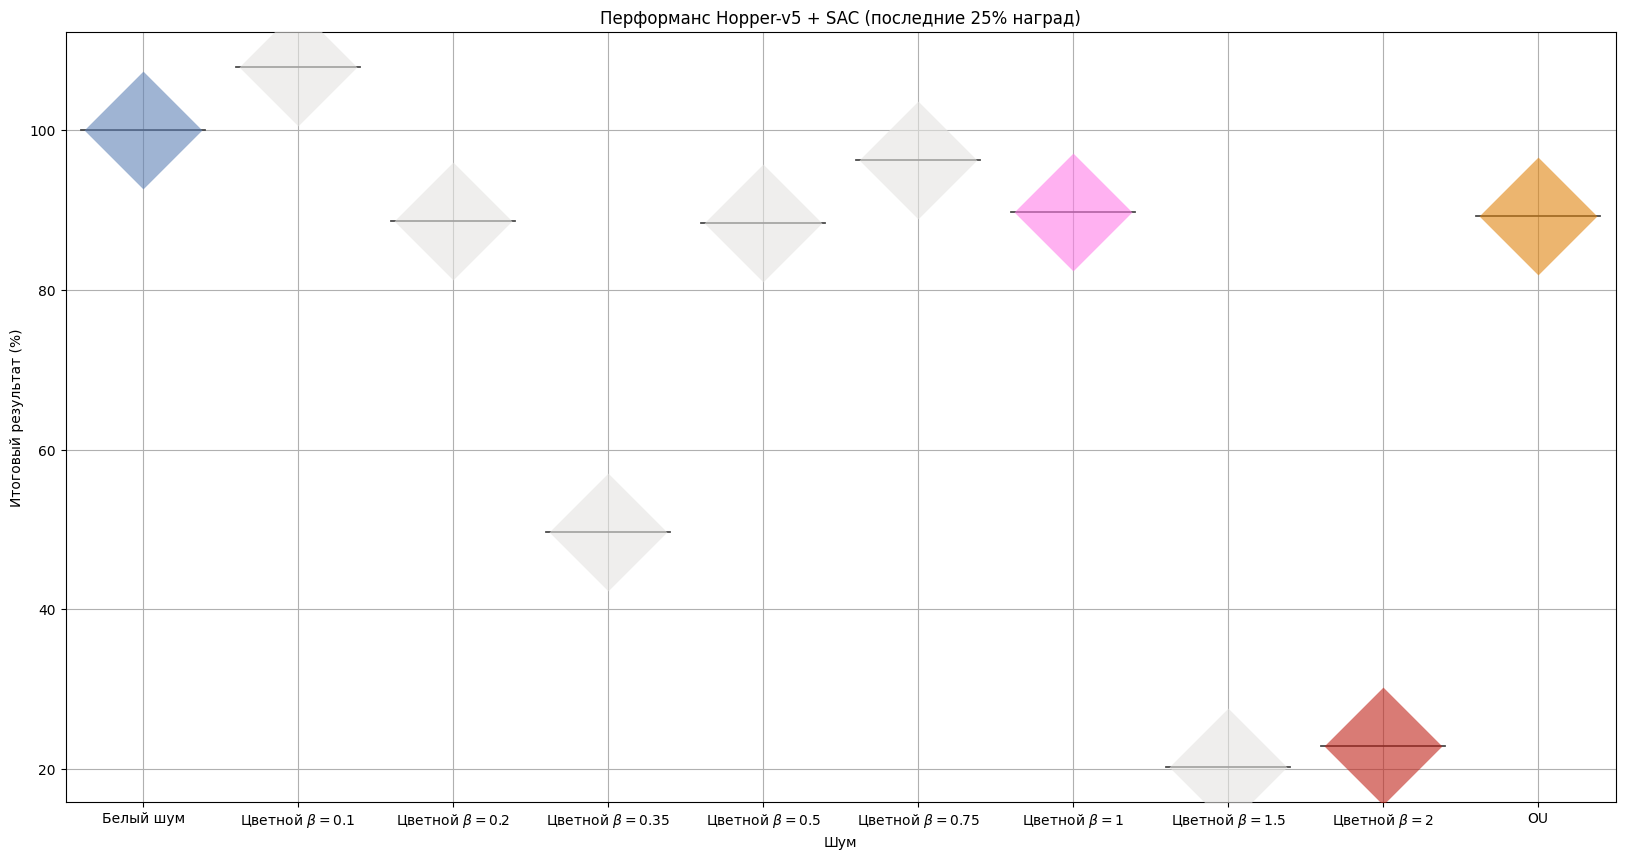

In [11]:
ENV_NAME = 'Hopper-v5'
ALG_NAME = SAC

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

[PLOT] Сохранён комбинированный график: ./results/Hopper-v5_TD3/Hopper-v5_TD3_combined_plot.png


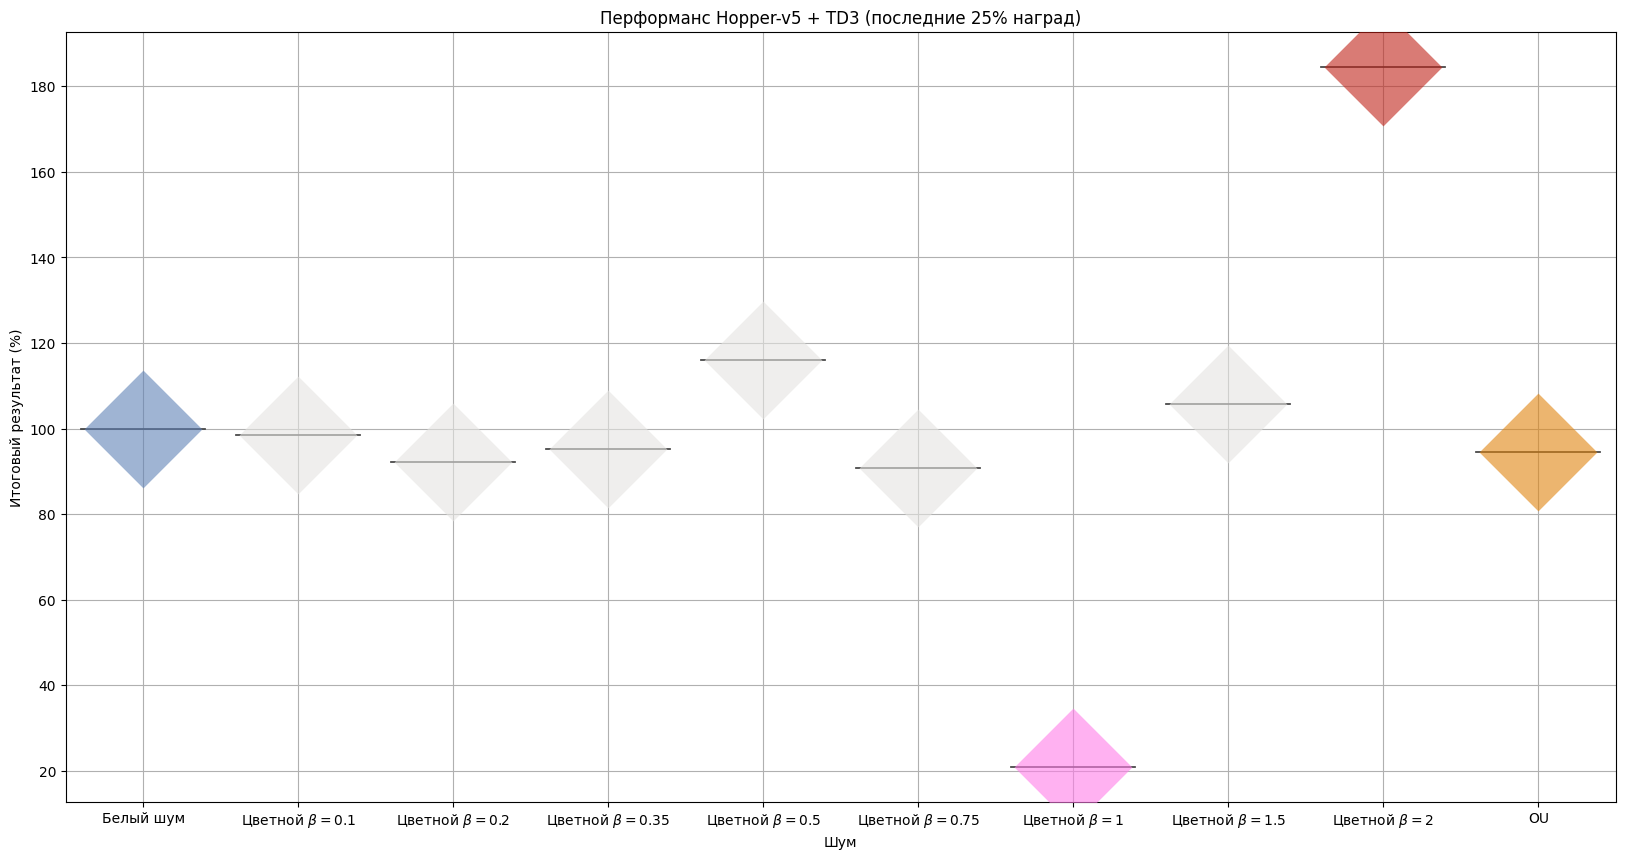

In [12]:
ENV_NAME = 'Hopper-v5'
ALG_NAME = TD3

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

[PLOT] Сохранён комбинированный график: ./results/Hopper-v5_DDPG/Hopper-v5_DDPG_combined_plot.png


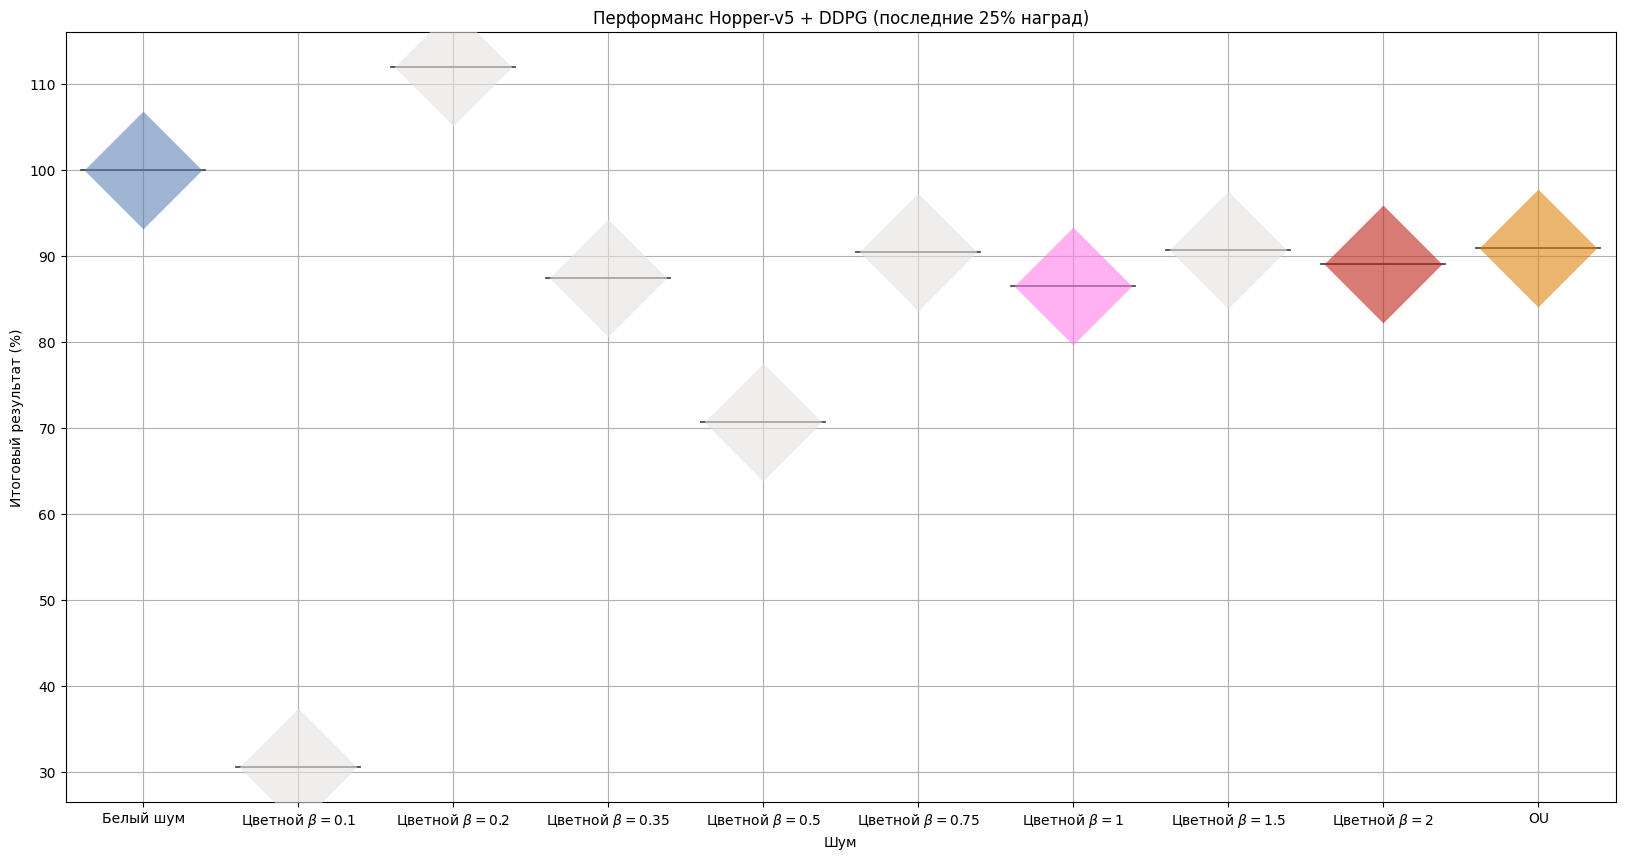

In [13]:
ENV_NAME = 'Hopper-v5'
ALG_NAME = DDPG

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

## HalfCheetah-v5

[PLOT] Сохранён комбинированный график: ./results/HalfCheetah-v5_SAC/HalfCheetah-v5_SAC_combined_plot.png


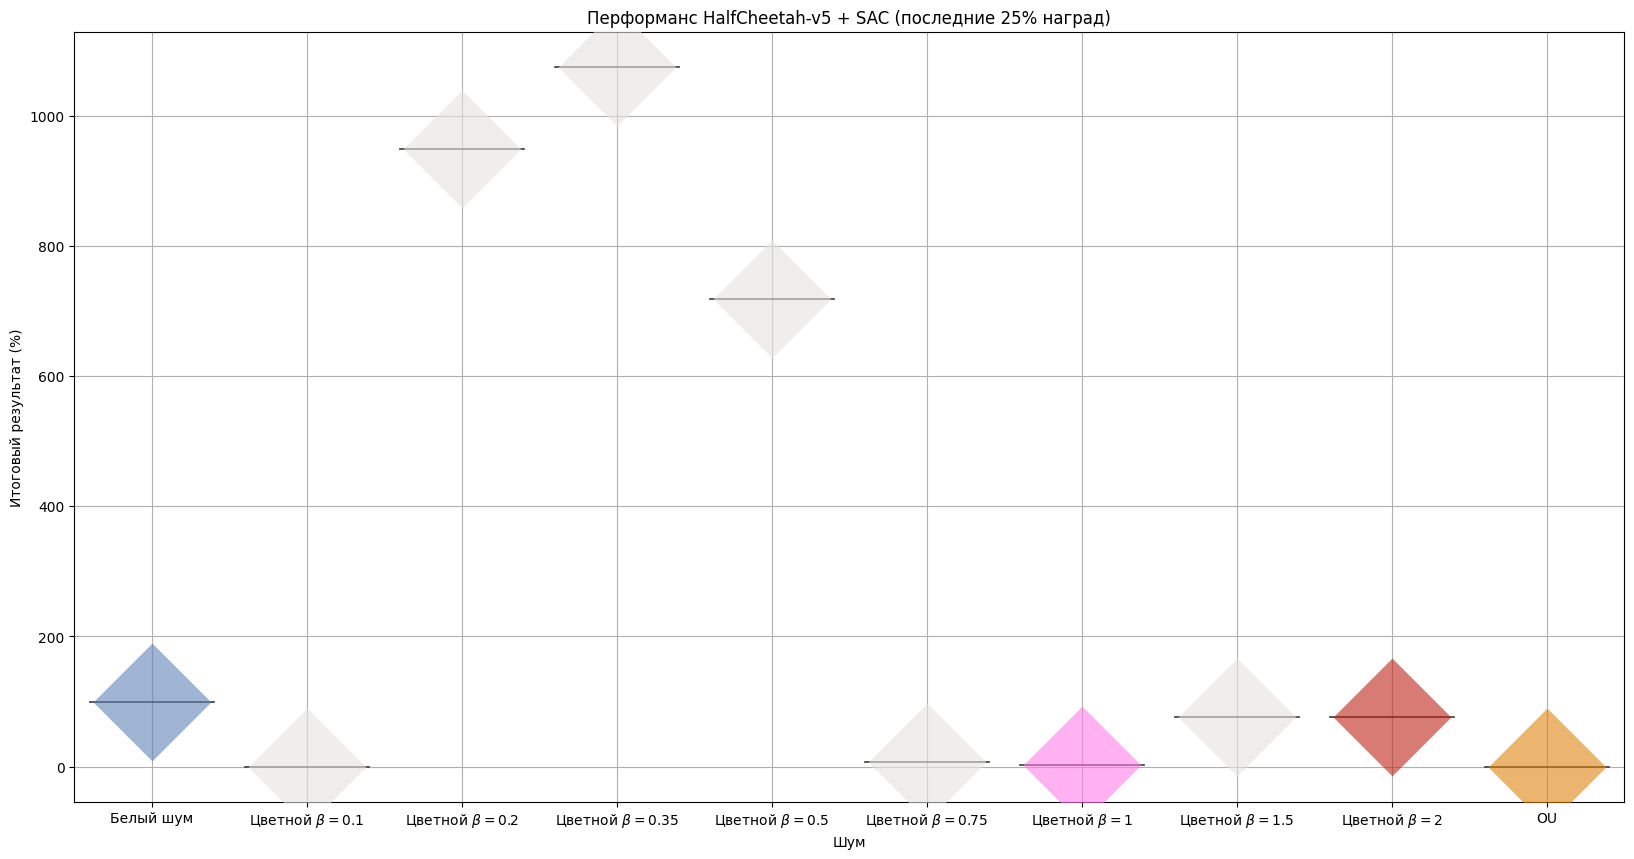

In [43]:
ENV_NAME = 'HalfCheetah-v5'
ALG_NAME = SAC

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

[PLOT] Сохранён комбинированный график: ./results/HalfCheetah-v5_TD3/HalfCheetah-v5_TD3_combined_plot.png


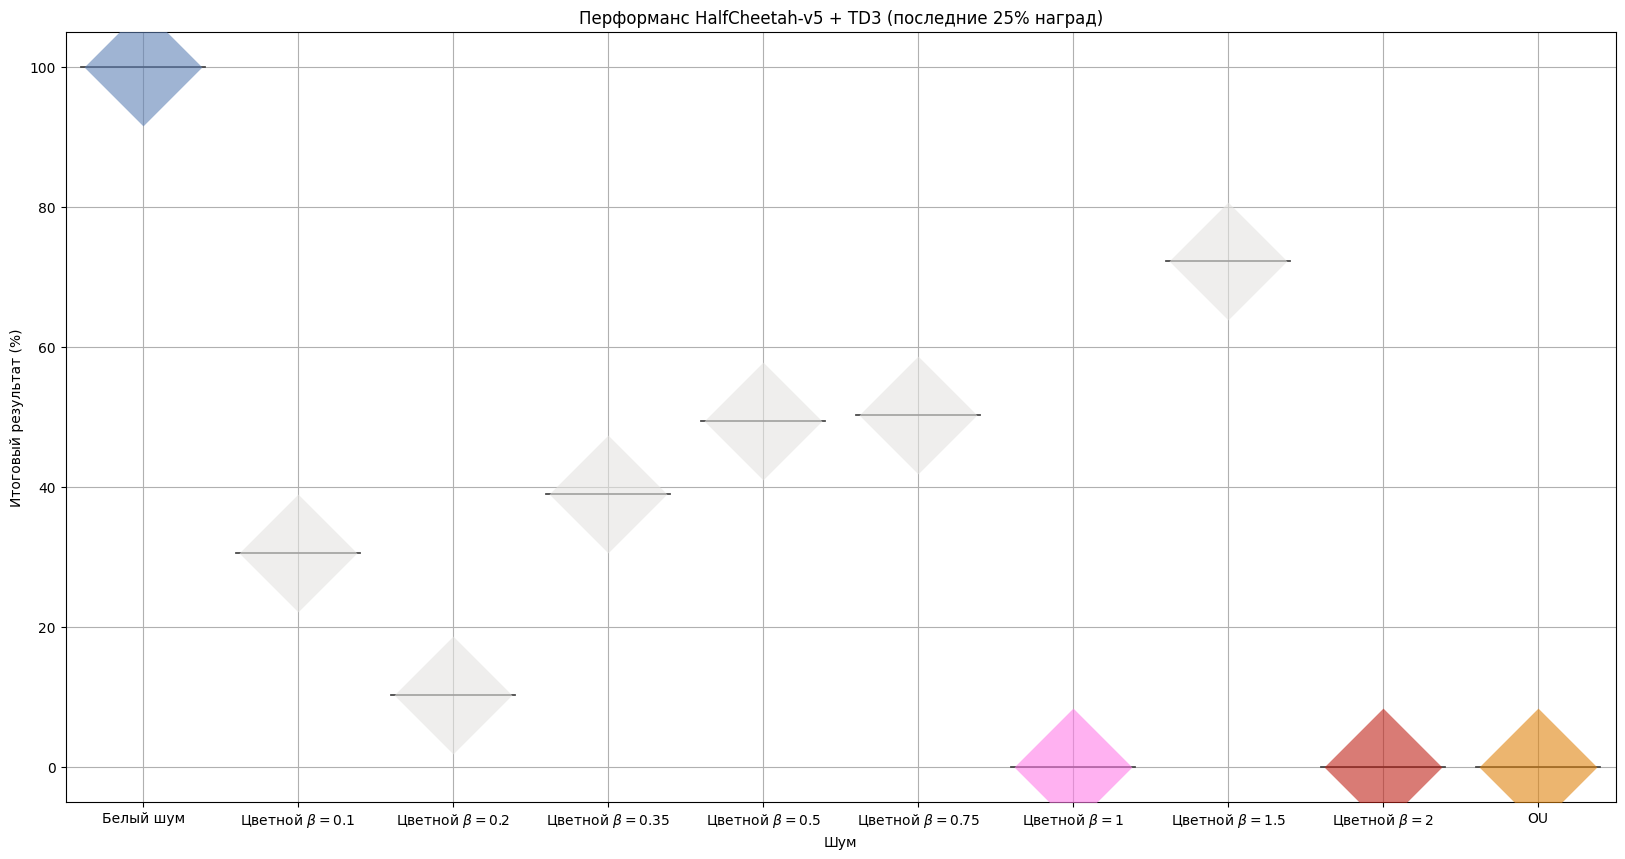

In [44]:
ENV_NAME = 'HalfCheetah-v5'
ALG_NAME = TD3

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

[PLOT] Сохранён комбинированный график: ./results/HalfCheetah-v5_DDPG/HalfCheetah-v5_DDPG_combined_plot.png


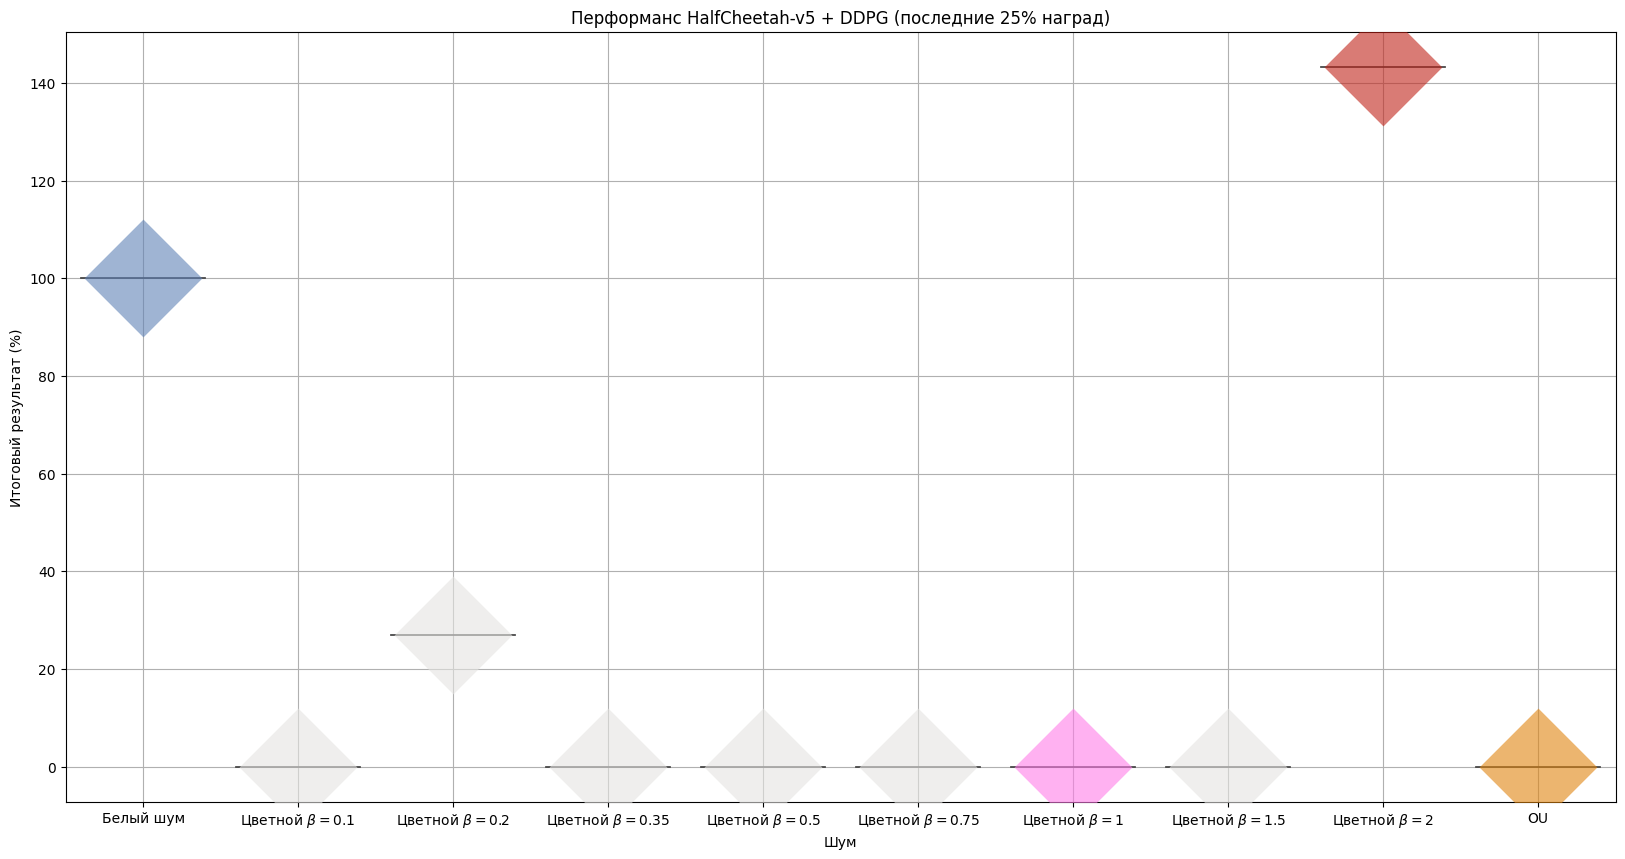

In [45]:
ENV_NAME = 'HalfCheetah-v5'
ALG_NAME = DDPG

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

## Walker2d-v5

[PLOT] Сохранён комбинированный график: ./results/Walker2d-v5_SAC/Walker2d-v5_SAC_combined_plot.png


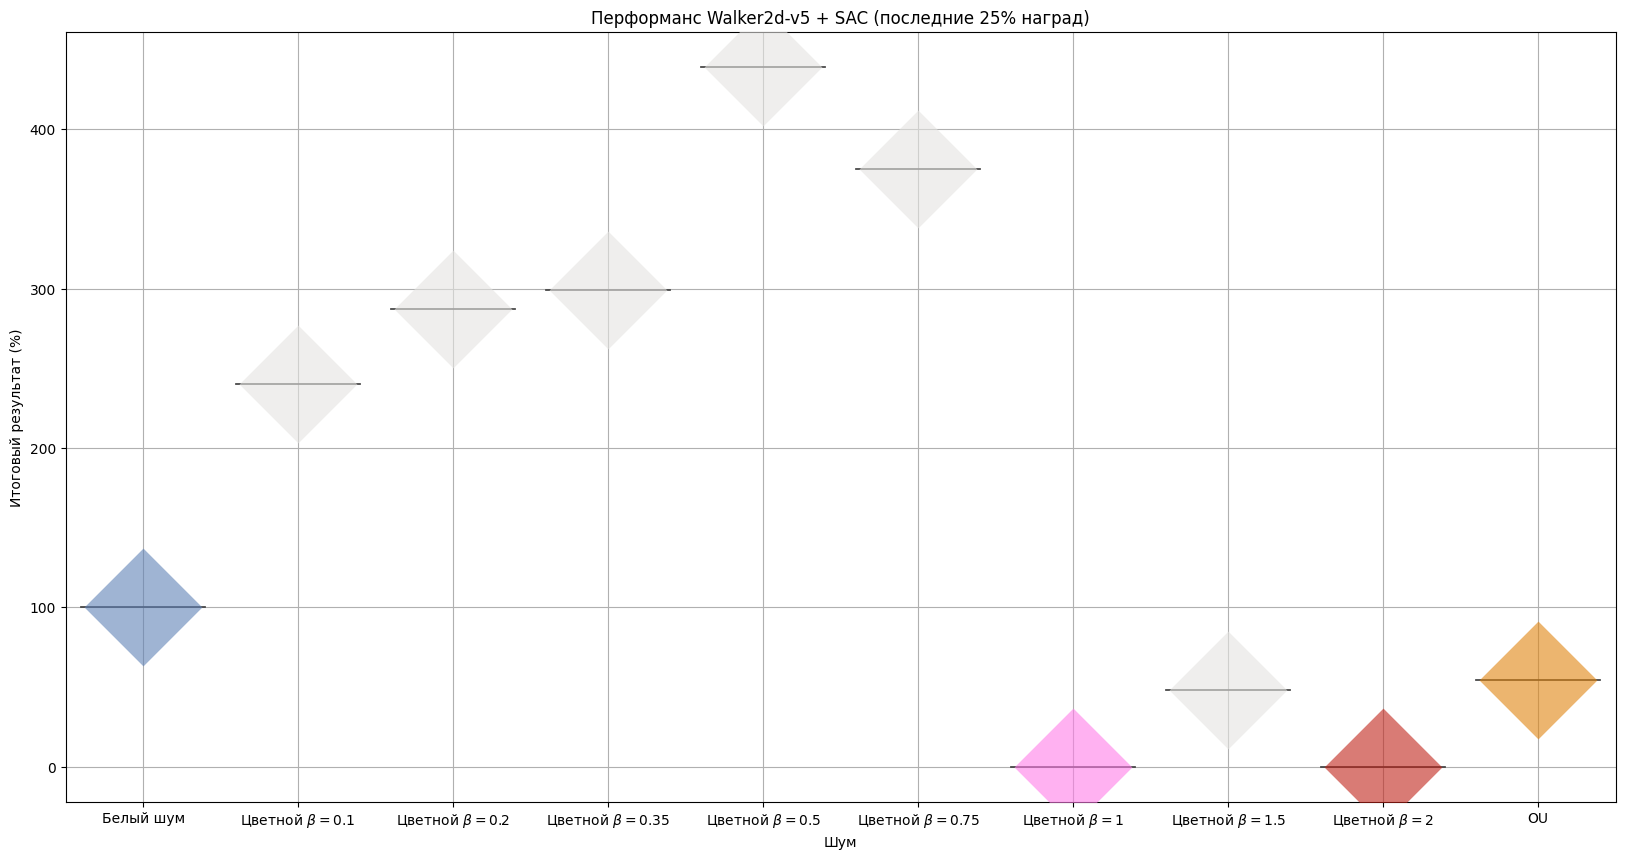

In [17]:
ENV_NAME = 'Walker2d-v5'
ALG_NAME = SAC

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

[PLOT] Сохранён комбинированный график: ./results/Walker2d-v5_TD3/Walker2d-v5_TD3_combined_plot.png


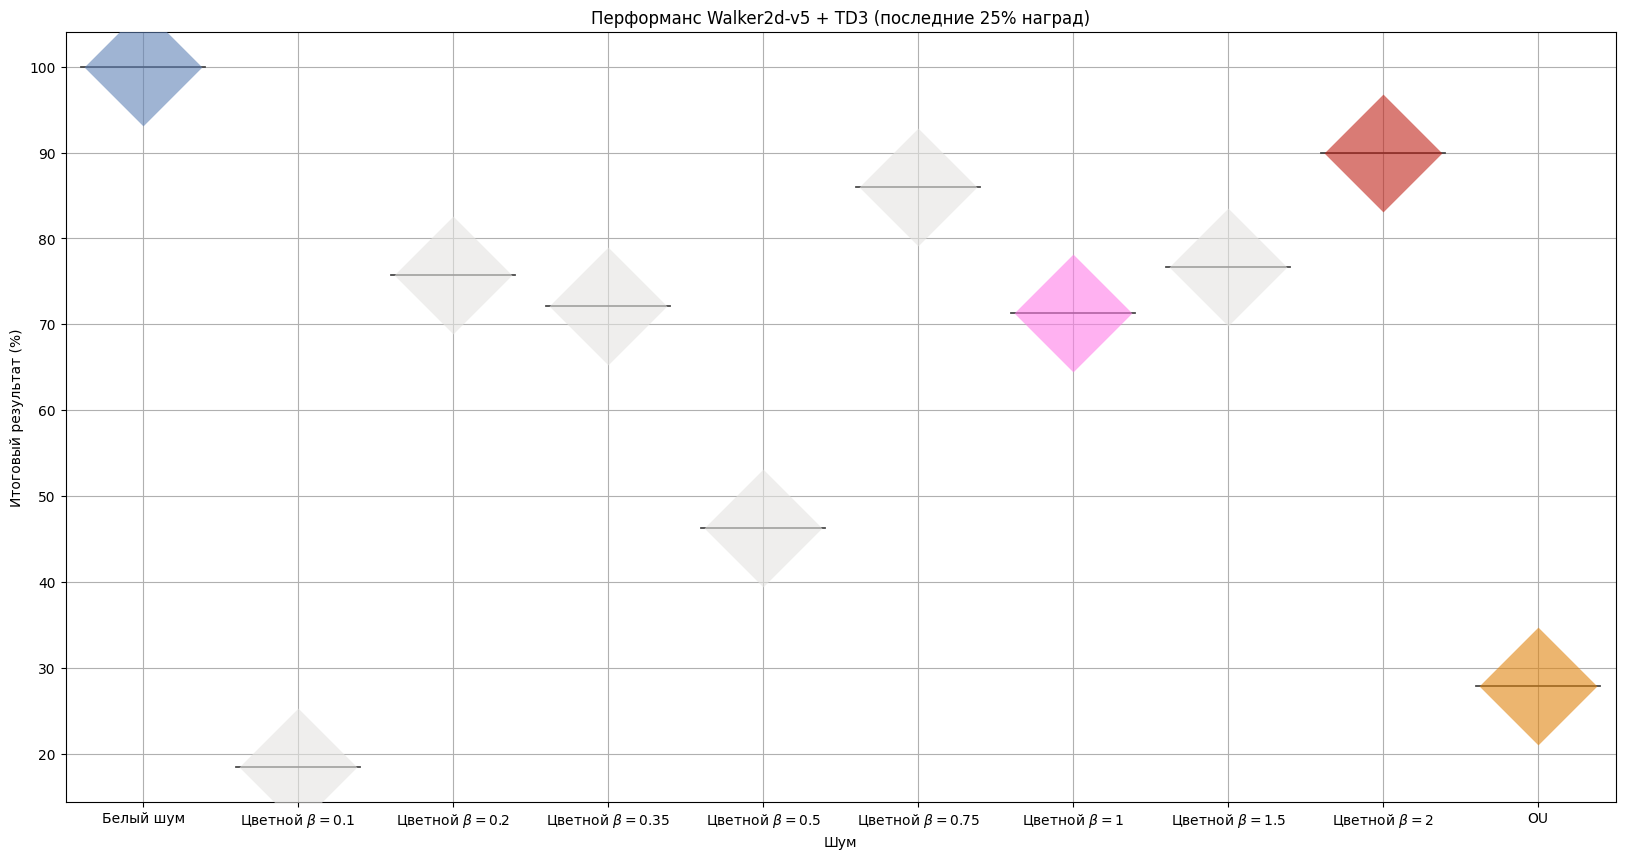

In [16]:
ENV_NAME = 'Walker2d-v5'
ALG_NAME = TD3

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)

[PLOT] Сохранён комбинированный график: ./results/Walker2d-v5_DDPG/Walker2d-v5_DDPG_combined_plot.png


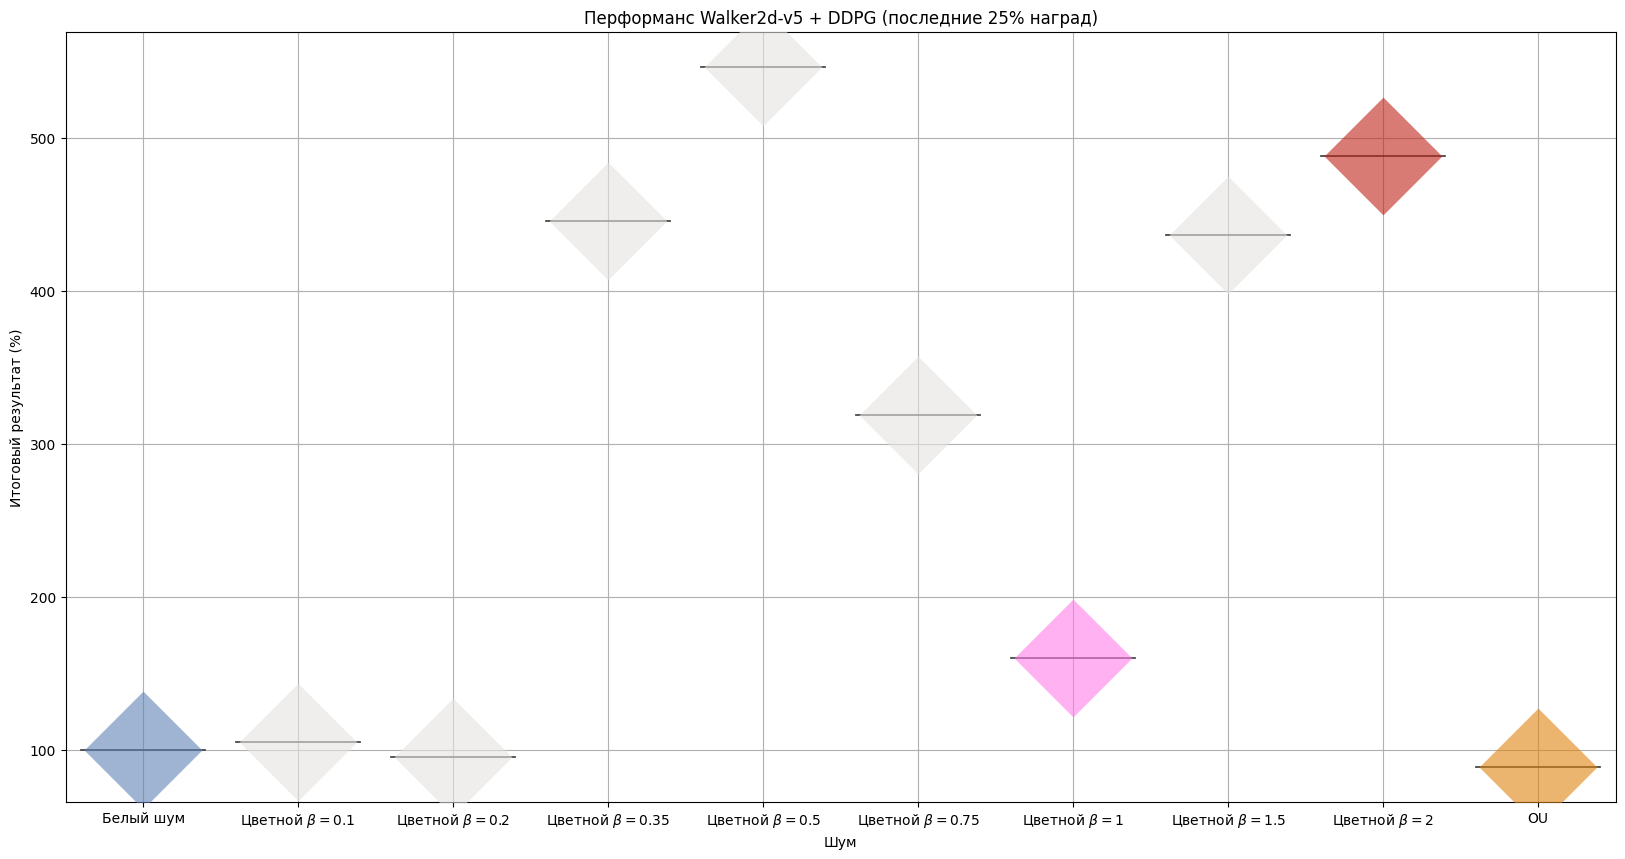

In [18]:
ENV_NAME = 'Walker2d-v5'
ALG_NAME = DDPG

plot_results_combined(
    global_results=global_results,
    env_name=ENV_NAME,
    alg_name=ALG_NAME,
    share=0.25,
    indices=None,
    save_fig=True,
    results_dir="./results",
    show=True,
    jitter=0.2,
    alpha=0.6,
    marker_size=60
)